In [1]:
#Importing Some Modules
import os 
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import skimage
import cv2

%matplotlib inline

In [1]:
#You Might Want to Rename the Directory....
TEST_IMG_DIR = "data/test"
TRAIN_IMG_DIR = "data/train"
IMAGE_SIZE = 32

#Function to Load the Data:
def load_data(data_dir, Train=True):
    #Each of the Folders Represent an Unique Sign Image(Encoded as Label)
    directories_data = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir,d))]
    #We can Store the Image data(Pixel Data) and Label(Corresp to the Image) 
    image = []
    label = []
    #Now getting the Each Image's Path for Feeding-In
    for d in directories_data:
        label_dir = os.path.join(data_dir,d)
        #The Extention of the IMG Files is .PPM
        img_path = [os.path.join(label_dir, img) for img in os.listdir(label_dir) if img.endswith(".ppm")]
        #Here Loading Each Image Data and Append them into the Array\
        for s in img_path:
            #Reducing the Computation By Gray Scaling
            image.append(cv2.resize(cv2.imread(s),(IMAGE_SIZE,IMAGE_SIZE)))
            label.append(int(d))
    if Train:
        np.save(f"img-train.npy",image)
        np.save(f"lab-train.npy",label)
    else:
        np.save(f"img-test.npy",image)
        np.save(f"lab-test.npy",label)
        
    return image, label

In [45]:
#Getting the Results for the Train Data
images, labels =  load_data(TRAIN_IMG_DIR)

In [46]:
#Now Let's SeenSome Unique Labels and Total Images in Training Set
print(f"Total Images in Training Set: {len(images)}\nTotal Number of Classes in Training Set: {len(set(labels))}")

Total Images in Training Set: 4575
Total Number of Classes in Training Set: 62


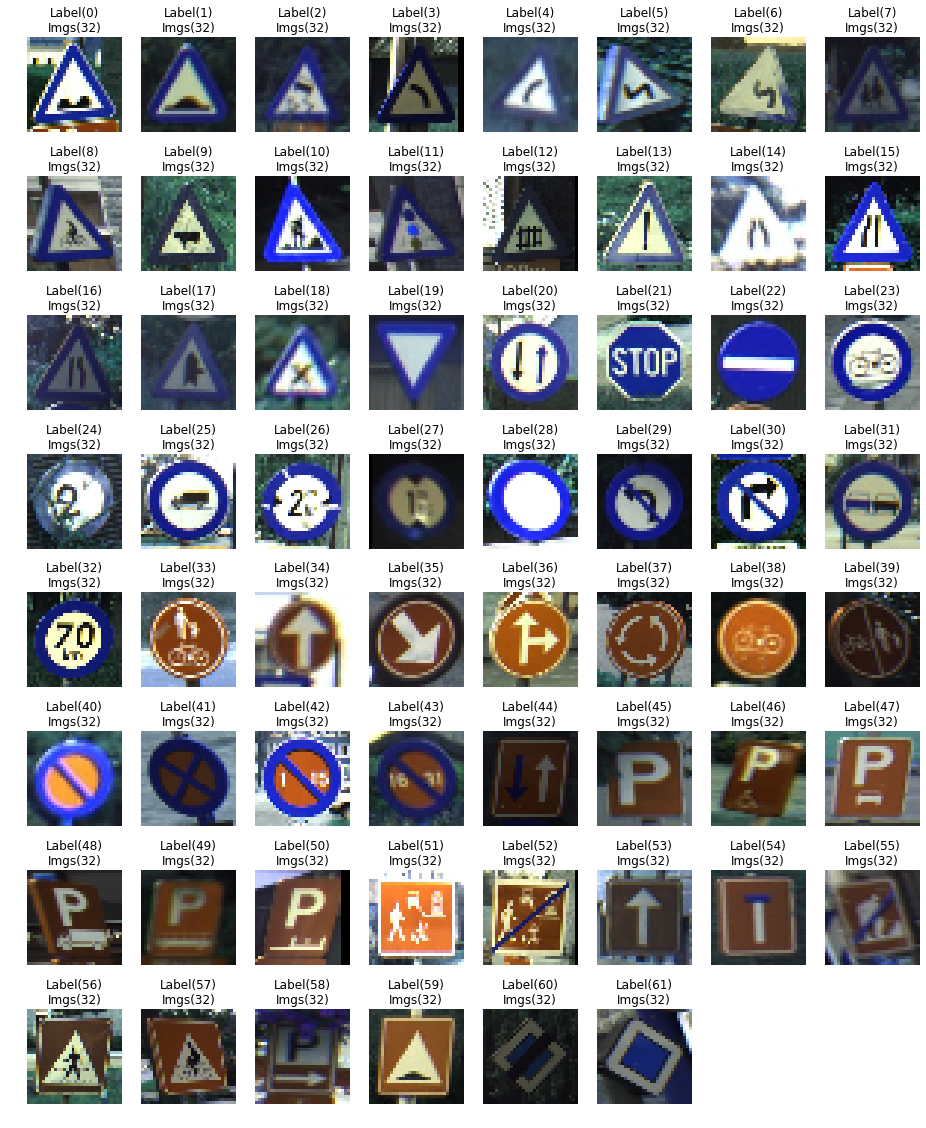

In [49]:
#Since there are 62 Classes in Training Set, It is Multi-Class Classification Problem
#Now Let's Display Some of the Images and It's True Labels:
def show_image_and_label(image,label):
    unique_labels = set(label)
    plt.figure(figsize=(16,20))
    i = 1
    for label in unique_labels:
        #Picking the Images for Each Unique Labels(With Their Index ID)
        image = images[labels.index(label)]
        #Ploting 8 Items in a Single Row
        plt.subplot(8,8, i)
        plt.axis("off")
        plt.title(f"Label({label})\nImgs({len(images[labels.index(label)])})")
        i += 1
        plt.imshow(image)
    plt.show()
show_image_and_label(images,labels)

In [71]:
#From the Figure We Notice that Images Come in Different Shape
#Let Me show You the Shape of First 3 Images on the Dataset
for i,img in enumerate(images[:3]):
    print(f"Image: {i+1} Shape: {img.shape}")
#There are three Colour Channels:RGB(Computationally Expensive) and Now I have Reduced the Dimention(1 Channel)
image_array = np.array(images)
label_array = np.array(labels)

Image: 1 Shape: (32, 32, 3)
Image: 2 Shape: (32, 32, 3)
Image: 3 Shape: (32, 32, 3)


#### We are Building a Convolutional Neural Network with the Random Weight Initilization By Xavier Initilization. Our Convolutional Layer is Followed by the Pooling Layer(Max Pooling). We Are Using Batch Normilization(For Better Weight Init). The Kernal Size is Two With a Stride of Two. The Flattern Layer is Followed By the Convolutional Layer(N, Height x Width x Channels[1]). Once It is Flatted, It is Fed Into a Fully Connected Convolutional Layer 1 and Followed By the Batch Normalization with DropOut. Then the Fully Connected Layer is Lightened Before Feeding Into the Softmax Layer. Beta and Gamma Are Learable Parameters
<hr />
<img src="bn.PNG" height="500" width="500">
<img src="cnnimg.png" />

In [63]:
#Now Let's Build the Convolutional Neural Network!
#First Defining the Computation graph:
graph = tf.Graph()
with graph.as_default():
    #Tensorflow Placeholder for Input Image and Labels(Accpects Array of Float):
    #Input of 32 x 32 Image with Single Color Channel
    image_x = tf.placeholder(tf.float32,shape=[None, 32,32,3])
    labels_x = tf.placeholder(tf.int32,[None])
    #Random Weight and Bias Initilizer --> Xavier Initilization
    biasInit = tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32)
    
    #Convolutional Network, Layer 1. Neurons:128 Kernel Size: 6 x 6(Filter)
    conv1 = tf.contrib.layers.conv2d(image_x, num_outputs=128, kernel_size=[6,6], biases_initializer=biasInit)
    
    #Applying Batch Norm for Layer 1.(Center Corres to Involvement of Beta + Z[i] * Gamma is Corres to scale)
    #The Two are the Lernable Parameters by Gradient Desent or Other Optimization Functions
    bn1 = tf.contrib.layers.batch_norm(conv1, center=True, scale=True, is_training=True)
    
    #Max-Pooling the Layer(Reduction of Computation)Kernel Size-->2 Stride-->2 :
    pool1 = tf.contrib.layers.max_pool2d(bn1, 2, 2)
    
    #Convolutional Network, Layer 2. Neurons:256 Kernel Size: 4 x 4(Filter)
    conv2 = tf.contrib.layers.conv2d(pool1, num_outputs=256, kernel_size=[4,4], stride=2, biases_initializer=biasInit)
    
    #BN For Conv Layer2:
    bn2 = tf.contrib.layers.batch_norm(conv2, center=True, scale=True, is_training=True)
    
    #Max-Pooling the Layer Kernel Size-->2(N x N) Stride-->2 :
    pool2 = tf.contrib.layers.max_pool2d(bn2, 2 ,2)
    
    #Flattening the Input Layer[None, Height, Width, Channels] to [None, Height x Width x  Channels]
    image_flat = tf.contrib.layers.flatten(pool2)
    
    #Fully Connected Layer - 1(With Activation Rectified Linear Unit)
    fc1 = tf.contrib.layers.fully_connected(image_flat, num_outputs=512, activation_fn=tf.nn.relu)
    
    #Batch Normilization for FC Layer
    bn3 = tf.contrib.layers.batch_norm(fc1, center=True, scale=True, is_training=True)
    
    #Applying Drop-Out For Better Learning Purposes:
    fc1 = tf.layers.dropout(bn3, rate=0.25, training=True)
    
    #Output Layer with 62 Neurons Which Denotes the 62 Classes for Prediction
    logits = tf.contrib.layers.fully_connected(fc1, num_outputs=62,activation_fn= tf.nn.relu)
    
    #Defining Cross-Entropy(Logarithmic Loss Function) --> Measures the Associativity Between Random Variables
    loss_p = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels_x))
    
    #Updating the Parameters(Learning Prams) Using the Optimization Function(Adam Optimizer)
    update_p = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_p):
        #Declaring Adam Optimizer for Training OP for NN
        train = tf.train.AdamOptimizer(learning_rate=0.10).minimize(loss_p)
    
    #Initilizing All the Computations(Conv Net)
    init = tf.global_variables_initializer()

In [69]:
print("images_flat: ", images_flat)
print("logits: ", logits)
print("loss: ", loss_p)
print("predicted_labels: ", predicted_labels)

images_flat:  Tensor("Flatten/flatten/Reshape:0", shape=(?, 4096), dtype=float32)
logits:  Tensor("fully_connected_1/Relu:0", shape=(?, 62), dtype=float32)
loss:  Tensor("Mean:0", shape=(), dtype=float32)
predicted_labels:  Tensor("ArgMax:0", shape=(?,), dtype=int64)


In [ ]:
#Creating the Session to Run the Computation Graph:
#If GPU is available, set log_device_placement to True

with tf.Session(graph=graph, config=tf.ConfigProto(log_device_placement=False)) as session:
    session.run(init)
    saver = tf.train.Saver()
    for i in range(10):
        _,loss_value = session.run([train, loss_p], feed_dict={image_x: image_array, labels_x:label_array})
        if i % 2 == 0: #For 2 Iterations
            print("Loss: {0}".format(loss_value))
        
    saver.save(session, 'sign_model')
